### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
# Computational packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
plt.style.use('../bioAI.mplstyle')

# General packages
import datetime
import sys
import os

# custom packages
import ratsimulator
from ratsimulator.Environment import Rectangle
import spatial_maps as sm # CINPLA spatial maps

# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 
from PlaceCells import PlaceCells
from Models import SorscherRNN
from Experiment import Experiment
from methods import *
from datahandling import *
from Plots import *
from plotting_functions import *

### Setup Experiment

In [3]:
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name := 'gg-3ME', base_path = base_path)
experiment.setup()

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


False

In [4]:
checkpoint_filenames = filenames(experiment.paths['checkpoints'])
# load model latest (wrt. #epochs trained)
print(f"Loading model at epoch = {checkpoint_filenames[-1]}")
checkpoint = torch.load(experiment.paths['checkpoints'] / checkpoint_filenames[-1])
with open(experiment.paths["experiment"] / "logger.pkl", "rb") as f:
    logger = pickle.load(f)

Loading model at epoch = 02999


### Helper functions

In [5]:
def metric_fraction_to_checkpoint(metric, ps=[0.9999, 0.95, 0.05]):
    # find training phases as a fraction of loss-differences
    metric = np.array(metric)
    metric_diff = np.max(metric) - np.min(metric)
    metric_phases = metric_diff * np.array(ps)
    metric_phases += np.min(metric)
    metric_phase_idxs = abs(metric_phases[:, None] - metric[None])  # shape: (3, #epochs)
    metric_phase_idxs = np.argmin(metric_phase_idxs, axis=-1)  # shape: (3,)

    # find closest (rounded) model checkpoints to the phase idxs
    checkpoint_filenames = filenames(experiment.paths["checkpoints"])
    checkpoint_nums = [
        int(checkpoint_filename) for checkpoint_filename in checkpoint_filenames
    ]
    save_freq = checkpoint_nums[2] - checkpoint_nums[1]
    checkpoint_phase_nums = baround(metric_phase_idxs, save_freq)
    checkpoint_phase_nums = np.minimum(checkpoint_phase_nums, np.max(checkpoint_nums))
    checkpoint_phase_filenames = [
        f"{checkpoint_phase_num:05d}.pkl"
        for checkpoint_phase_num in checkpoint_phase_nums
    ]
    return checkpoint_phase_filenames, checkpoint_phase_nums

def load_grid_scores():
    # load grid scores for environments
    score_maps = []
    sorted_idxs = []
    for grid_score_filename in filenames(experiment.paths["grid_scores"]):
        with open(experiment.paths["grid_scores"] / grid_score_filename, "rb") as f:
            score_map = pickle.load(f)
        sorted_idxs.append(np.argsort(score_map)[::-1])
        score_maps.append(score_map)

    # select the best cell for each environment separately
    selected_sorted_cells_idxs = []
    for env_i in range(len(experiment.environments)):
        selected_sorted_cells_idxs.append(sorted_idxs[env_i][0])
    selected_sorted_cells_idxs.append(1) # add a fourth random cell

    # get the grid score for each of the "selected" cells
    selected_cell_scores = []
    for env_i in range(len(experiment.environments)):
        selected_cell_scores.append([])
        for selected_sorted_cells_idx in selected_sorted_cells_idxs:
            selected_cell_scores[env_i].append(
                np.around(score_maps[env_i][selected_sorted_cells_idx], decimals=2)
            )

    return selected_sorted_cells_idxs, selected_cell_scores

checkpoint_phase_filenames, checkpoint_phase_nums = metric_fraction_to_checkpoint(logger.training_metrics['familiar']['KL'])
selected_sorted_cells_idxs, selected_cell_scores = load_grid_scores()

In [6]:
panesize = set_size(width=345, mode='square')
panesize

(4.77376504773765, 4.77376504773765)

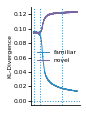

In [7]:
#figsize=(panesize[0]/3, panesize[1]/4) # histories beneath
figsize=(panesize[0]/4, panesize[1]/3) # histories to left
fig, ax = plt.subplots(figsize=figsize)
ax.plot(logger.training_metrics['familiar']['KL'],label='familiar')
ax.plot(logger.training_metrics['novel']['KL'],label='novel')
ax.legend()
ax.axhline(0,ls=":")
ax.set_ylabel('KL-Divergence')
ax.xaxis.set_visible(False)
[ax.axvline(num, linestyle=":") for num in checkpoint_phase_nums]

os.makedirs(experiment.paths['experiment'] / 'plots', exist_ok=True)
fig.savefig(experiment.paths['experiment'] / 'plots/loss-history')

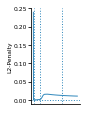

In [8]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(logger.training_metrics['familiar']['l2_reg'])
ax.axhline(0,ls=":")
ax.set_ylabel('L2-Penalty')
ax.xaxis.set_visible(False)
[ax.axvline(num, linestyle=":") for num in checkpoint_phase_nums]

fig.savefig(experiment.paths['experiment'] / 'plots/l2-penalty')

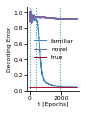

In [9]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(logger.training_metrics['familiar']['pred_error'],label='familiar')
ax.plot(logger.training_metrics['novel']['pred_error'],label='novel')
ax.plot(logger.training_metrics['familiar']['true_error'],label='true')
ax.legend()
ax.set_ylabel('Decoding Error')
ax.set_xlabel('t [Epochs]')
[ax.axvline(num, linestyle=":") for num in checkpoint_phase_nums]

fig.savefig(experiment.paths['experiment'] / 'plots/decoding-error')

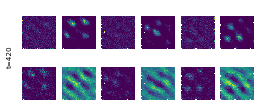

In [10]:
#figsize=(panesize[0], panesize[1]/4) # histories beneath
figsize=(panesize[0]*3/4, panesize[1]/3) # histories to the left
fig, axs = plt.subplots(nrows=2,ncols=6,figsize=figsize)
[axis_off_labels_on(ax) for ax in axs.flat]
#selected_sorted_cells = [20, 51, 2048, 4095]
#selected_sorted_cells = [0, 1, 7, 8]

j = 1# MANUALLY CHOOSE j=0, j=1 and j=2
fig.supylabel(f't={checkpoint_phase_nums[j]}')
checkpoint_phase_filename = checkpoint_phase_filenames[j]

for env_i in range(len(experiment.environments)):
    ratemap_filename = (
        experiment.paths["ratemaps"]
        / f"env_{env_i}"
        / checkpoint_phase_filename
    )
    with open(ratemap_filename, "rb") as f:
        ratemaps_i = pickle.load(f)

    for ratemap_example_k in range(num_ratemap_examples := 4):
        ratemap_idx = selected_sorted_cells_idxs[ratemap_example_k]
        ratemap_score = selected_cell_scores[env_i][ratemap_example_k]
        ratemap = ratemaps_i[ratemap_idx]
        ax = axs[(ratemap_example_k//2), env_i*2 + (ratemap_example_k%2)]
        ax.imshow(ratemap)
        if j == 0 and env_i == 0:
            ax.set_title(f"id={ratemap_idx}")
        elif j == len(checkpoint_phase_filenames) - 1:
            ax.set_title(f"gsc={ratemap_score}")
        else:
            # consistent ratemap size with/without title
            ax.set_title(" ")
            
fig.savefig(experiment.paths['experiment'] / f'plots/ratemap-dynamics-t{j}')